In [1]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import numpy as np
import re
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob 
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

In [2]:
#nltk.download('vader_lexicon')

In [3]:
# initialize a stemmer (removes affixes to index the words better)
porter = PorterStemmer()
# define all stopwords
n_words= set(stopwords.words('english'))

In [4]:
class EDA:
    def __init__(self, dataset):
        self.data = pd.read_csv(dataset)
        
    def plot_stats(self):
        # output various plots/graphs to understand the data better
        seaborn.countplot(x = "Sentiment", data=self.data)
        plt.xlabel("Sentiment", size=15)
        plt.ylabel("Count", size=15)
        plt.title("Count of all text sentiments", size=17)
        plt.show()
        
        # create subplots representing the distribution of text lengths for every sentiment
        grid = seaborn.FacetGrid(self.data, col = "Sentiment")
        grid.map(plt.hist, "Length")
        plt.show()
        
    def clean(self, method):
        for text in self.data["Text"]:
            # remove unnecessary characters that do not impact the outcome
            # tokenize the data
            # remove @ tags and links from the text
            text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])" \
                                  "|(\w+:\/\/\S+)", " ", text).split()) 
            # convert all letters to lower case and replacing '-' with spaces.
            text = text.lower().replace('-', ' ')
            # remove stowards and numbers
            table = str.maketrans('', '', string.punctuation+string.digits)
            text = text.translate(table)
            if method == "rule-based":
                # tokenize words 
                tokens = word_tokenize(text)
                # stem the words 
                stemmed = [porter.stem(word) for word in tokens]
                words = [w for w in stemmed if not w in n_words]
                text = ' '.join(words)
        return self.data

In [5]:
class RuleBased:
    def __init__(self, cleaned_data, model_name):
        self.data = cleaned_data
        self.model_name = model_name
        if self.model_name == "VADER":
            self.sid = SentimentIntensityAnalyzer()
        
    def classify(self):
        sentiment_scores = []
        if self.model_name == "VADER":
            # iterate through every tweet
            for tweet in self.data["Text"]:
                # get the polarity score
                score = self.sid.polarity_scores(tweet)
                # append the result
                sentiment_scores.append(score["compound"])
        else:
            # iterate through every tweet
            for tweet in self.data["Text"]:
                processed_tweet = TextBlob(tweet)
                # get the polarity score
                score = processed_tweet.sentiment.polarity
                # append the result
                sentiment_scores.append(score)
        return sentiment_scores
    
    def show_confusion_matrix(self, confusion_matrix):
        hmap = seaborn.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
        plt.ylabel('True sentiment')
        plt.xlabel('Predicted sentiment')
        plt.show()
    
    
    def calculate_accuracy(self):
        predictions = self.classify()
        self.data["Score"] = predictions 
        
        if self.model_name == "VADER":
            # thresholds suggested here: 
            # https://digitalenvironment.org/natural-language-processing-vader-sentiment-analysis-with-nltk/
            self.data["Prediction"] = self.data["Score"].apply(lambda s: "positive" if s >=0.05 \
                                                               else "neutral" if -0.05 < s < 0.05 \
                                                               else "negative")
        else:
            
            self.data["Prediction"] = self.data["Score"].apply(lambda s: "positive" if s > 0 \
                                                               else "neutral" if s == 0 \
                                                               else "negative")
        # compare predictions to the classifications initially present in the dataset
        matched = 0
        for orig, pred in zip(self.data["Sentiment"], self.data["Prediction"]):
            if orig == pred:
                matched += 1

        print(f"{self.model_name} model accuracy: {round(matched/self.data.shape[0]*100, 2)}%")
        
        class_names = ["negative", "neutral", "positive"]
        
        print(classification_report(self.data["Sentiment"], self.data["Prediction"],
                                   target_names=class_names))
        
        cm = confusion_matrix(self.data["Sentiment"], self.data["Prediction"])
        df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
        self.show_confusion_matrix(df_cm)

In [9]:
class LSTM_NN:
    def __init__(self, cleaned_data):
        self.data = cleaned_data
        # number of samples processed before the model is updated
        self.batch_size = 256
        # number of complete passes through the dataset
        self.epochs = 5
        # maximum number of words to store in the vocabulary
        self.max_features = 10000
        # to be initialized during later stages
        self.X_train, self.X_dev, self.X_test = None, None, None
        self.y_train, self.y_dev, self.y_test = None, None, None
        self.classes = None
        self.model, self.trained_model = None, None
    
    def split(self, validation=False):
        # define independent and outcome variables
        X = self.data["Text"]
        # one-hot encode outcome variable (its default values were qualitative)
        y = pd.get_dummies(self.data["Sentiment"]).values
        # count number of distinct outcomes (same as 3 labels seen above)
        self.classes = len(y[0])
        # split the data into train and test sets
        self.X_train, self.X_test, self.y_train, \
        self.y_test = train_test_split(X, y, 
                                       test_size=0.3,
                                       stratify=y,
                                       random_state=123)
        
        if validation == True:
            self.X_dev, self.X_test, self.y_dev, \
            self.y_test = train_test_split(self.X_test, self.y_test,
                                           test_size=0.7,
                                           stratify=self.y_test,
                                           random_state=123)
        
       
    def visualize(self):
        # count the number of words in every entry (cleaned and tokenized)
        # we take train set as a benchmark
        words = [len(t) for t in self.X_train]
        plt.figure(figsize=(6, 4))
        plt.hist(words)
        plt.title(f"Distribution of word frequencies (by entry)", size=16)
        plt.xlabel("Words", size=14)
        plt.ylabel("Frequency", size=14)
        plt.show()
        return max(words)
        
    def tokenize(self, validation=False):
        # tokenize the input
        tokenizer = Tokenizer(num_words=self.max_features)
        # update internal vocabulary based on the train set
        tokenizer.fit_on_texts(list(self.X_train))
        # transform each tweet into a sequence of integers
        self.X_train = tokenizer.texts_to_sequences(self.X_train)
        self.X_test = tokenizer.texts_to_sequences(self.X_test)
        # visualize the word frequency after the input is cleaned and tokenized
        words = self.visualize()
        if validation == True:
            self.X_dev = tokenizer.texts_to_sequences(self.X_dev)
            self.X_dev = pad_sequences(self.X_dev, maxlen=words)
        # define the maximum number of words to keep based on word frequency
        self.X_train = pad_sequences(self.X_train, maxlen=words)
        self.X_test = pad_sequences(self.X_test, maxlen=words)
        #print(self.X_train.shape, self.X_test.shape)
        
    
    def build_model(self):
        """
        Builds an LSTM model

        Returns: deep neural network object
        """
        # helps avoid clutter from old models and layers
        keras.backend.clear_session()
        self.model = Sequential()
        self.model.add(Embedding(self.max_features, 100, 
                            input_length=self.X_train.shape[1]))
        self.model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
        self.model.add(Dense(self.classes, activation="softmax"))
        self.model.compile(loss="categorical_crossentropy", optimizer="adam", 
                      metrics=["accuracy"])
    
    def train(self, validation=False):
        """
        Trains the model.
        
        Returns: trained deep neural network object
        """
        
        if validation == True:
            self.trained_model = self.model.fit(self.X_train, self.y_train, 
                                                validation_data=(self.X_dev, 
                                                                 self.y_dev), 
                                                epochs=self.epochs, 
                                                batch_size=self.batch_size, 
                                                verbose=2)
        else:
            self.trained_model = self.model.fit(self.X_train, self.y_train, 
                                                validation_data=(self.X_test, 
                                                                 self.y_test), 
                                                epochs=self.epochs, 
                                                batch_size=self.batch_size, 
                                                verbose=2)
    
    def plot_accuracy_loss(self):
        """
        Plots accuracy and loss achieved during model training.
        """
        fig, axs = plt.subplots(1, 2,figsize=(12,4))
        axs[0].plot(range(1,self.epochs+1), 
                    self.trained_model.history["accuracy"])
        axs[0].plot(range(1,self.epochs+1), 
                    self.trained_model.history["val_accuracy"])
        axs[0].set_title("Model Accuracy", size=16)
        axs[0].set_xlabel("Epoch", size=14)
        axs[0].set_ylabel("Accuracy", size=14)
        axs[0].legend(["train", "validation"], loc="best")

        axs[1].plot(range(1,self.epochs+1), 
                    self.trained_model.history["loss"])
        axs[1].plot(range(1,self.epochs+1), 
                    self.trained_model.history["val_loss"])
        axs[1].set_title("Model Loss", size=16)
        axs[1].set_xlabel("Epoch", size=14)
        axs[1].set_ylabel("Loss", size=14)
        axs[1].legend(["train", "validation"], loc="best")
        plt.show()
        
    def show_confusion_matrix(self, confusion_matrix):
        hmap = seaborn.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
        plt.ylabel('True sentiment')
        plt.xlabel('Predicted sentiment')
        plt.show()
        
    def predict(self):
        # predict sentiments of the test set
        preds = np.argmax(self.model.predict(self.X_test, 
                                             batch_size=self.batch_size), 
                          axis=-1)
        
        # convert tests labels to single-digits instead of one-hot encoding
        print(f"Accuracy (test set): "
              f"{np.round(accuracy_score(np.argmax(self.y_test,axis=1), preds)*100, 2)}%\n")
        
        class_names = ["negative", "neutral", "positive"]
        
        print(classification_report(np.argmax(self.y_test,axis=1), preds,
                                   target_names=class_names))
        
        cm = confusion_matrix(np.argmax(self.y_test,axis=1), preds)
        df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
        self.show_confusion_matrix(df_cm)

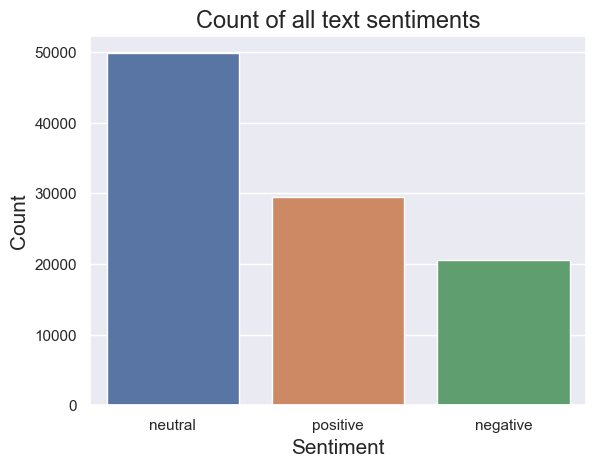

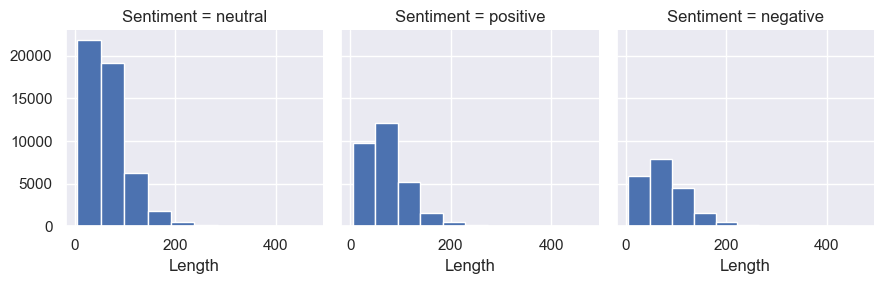

In [7]:
data_path = "model data.csv"
data = EDA(data_path)
data.plot_stats()
cleaned_rb_data = data.clean(method="rule-based")
cleaned_ml_data = data.clean(method="ml")
cleaned_transformer_data = data.clean(method="transformer")
# make copies of cleaned data for future use
vader_data = cleaned_rb_data.copy()
textblob_data = cleaned_rb_data.copy()
lstm_data = cleaned_ml_data.copy()
bert_data = cleaned_transformer_data.copy()
roberta_data = cleaned_transformer_data.copy()

VADER model accuracy: 58.84%
              precision    recall  f1-score   support

    negative       0.49      0.41      0.45     20502
     neutral       0.68      0.64      0.66     49802
    positive       0.51      0.63      0.57     29402

    accuracy                           0.59     99706
   macro avg       0.56      0.56      0.56     99706
weighted avg       0.59      0.59      0.59     99706



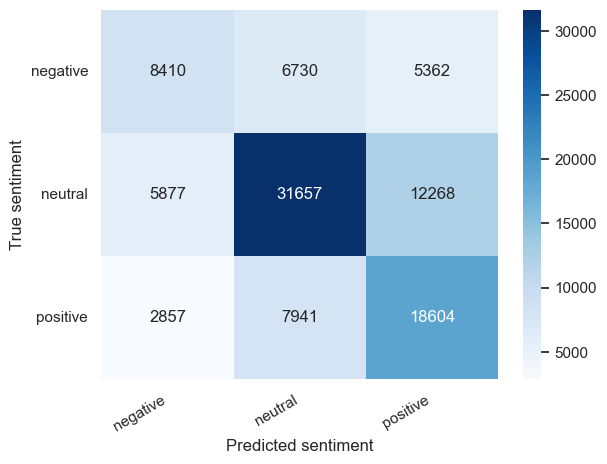

In [8]:
vader = RuleBased(cleaned_data=vader_data, model_name="VADER")
vader.classify()
vader.calculate_accuracy()

TextBlob model accuracy: 54.17%
              precision    recall  f1-score   support

    negative       0.40      0.37      0.38     20502
     neutral       0.67      0.56      0.61     49802
    positive       0.47      0.63      0.54     29402

    accuracy                           0.54     99706
   macro avg       0.51      0.52      0.51     99706
weighted avg       0.56      0.54      0.54     99706



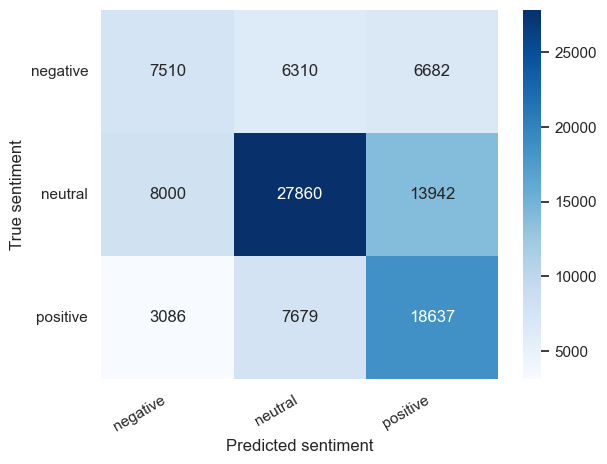

In [9]:
textblob = RuleBased(cleaned_data=textblob_data, model_name="TextBlob")
textblob.classify()
textblob.calculate_accuracy()

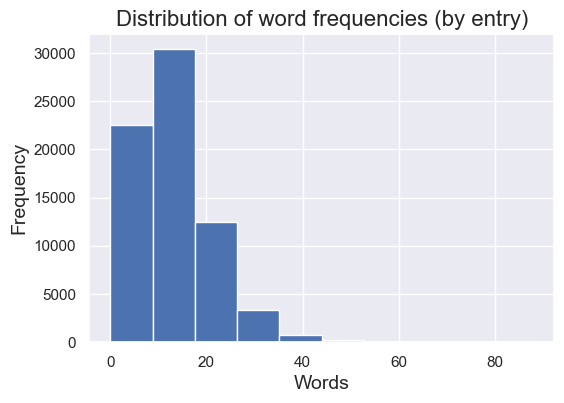

In [10]:
lstm_ = LSTM_NN(cleaned_data=lstm_data)
lstm_.split(validation=True)
lstm_.tokenize(validation=True)

In [24]:
lstm_.build_model()
lstm_.train(validation=True)

Epoch 1/5
273/273 - 196s - loss: 0.8700 - accuracy: 0.6081 - val_loss: 0.7532 - val_accuracy: 0.6857 - 196s/epoch - 717ms/step
Epoch 2/5
273/273 - 194s - loss: 0.7058 - accuracy: 0.7042 - val_loss: 0.7269 - val_accuracy: 0.7041 - 194s/epoch - 711ms/step
Epoch 3/5
273/273 - 198s - loss: 0.6527 - accuracy: 0.7301 - val_loss: 0.7257 - val_accuracy: 0.7057 - 198s/epoch - 726ms/step
Epoch 4/5
273/273 - 197s - loss: 0.6158 - accuracy: 0.7480 - val_loss: 0.7442 - val_accuracy: 0.7010 - 197s/epoch - 723ms/step
Epoch 5/5
273/273 - 195s - loss: 0.5790 - accuracy: 0.7633 - val_loss: 0.7571 - val_accuracy: 0.6878 - 195s/epoch - 714ms/step


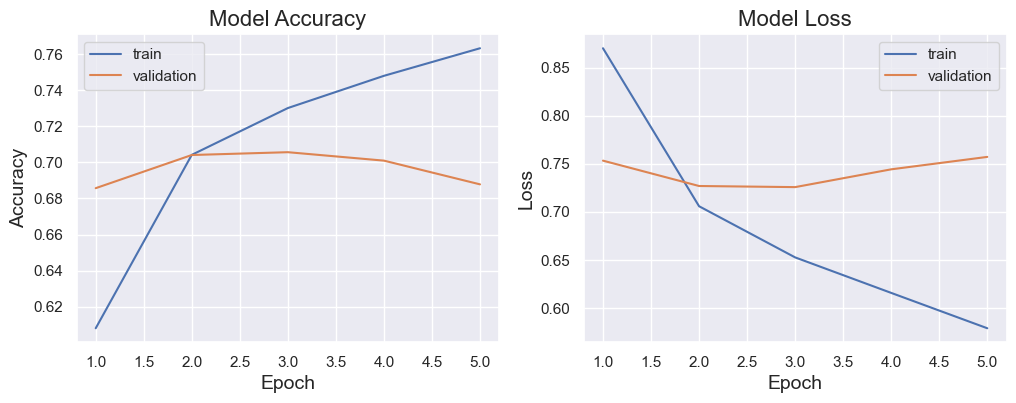

82/82 [==============================] - 6s 72ms/step
Accuracy (test set): 67.5%

              precision    recall  f1-score   support

    negative       0.52      0.59      0.55      4305
     neutral       0.75      0.76      0.75     10459
    positive       0.68      0.60      0.63      6175

    accuracy                           0.67     20939
   macro avg       0.65      0.65      0.65     20939
weighted avg       0.68      0.67      0.68     20939



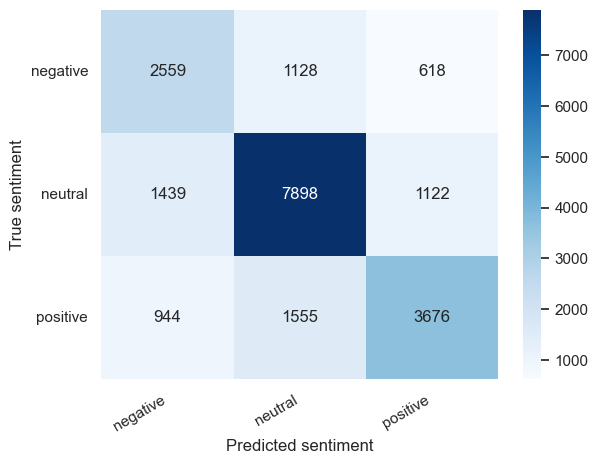

In [25]:
lstm_.plot_accuracy_loss()
lstm_.predict()